In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [68]:
from keras.models import load_model
import os
from keras.initializers import glorot_uniform
from keras.initializers import glorot_uniform
from keras.utils.generic_utils import get_custom_objects
import _pickle as pickle
from model import model_predict
from data_prepare import categorical_factory
from performance import performance_factory

In [121]:
function = "params_select"
# # sz50
# uid1 = 'test_model01'
# uid2 = 'fc7fbff0-f5e9-11e7-b733-525400f48026'

# hs300
# uid1 = 'test_hs300_model01'
# uid2 = 'e0a5c034-f690-11e7-b733-525400f48026'

# zz500
# uid1 = 'test_zz500_model03'
# # uid2 = 'c5d6287c-f68e-11e7-b733-525400f48026'
# uid2 = '1c293374-f764-11e7-b733-525400f48026'

# zz500_idx
# uid1 = 'caosg'
# uid2 = 'ace215d8-f87d-11e7-b733-525400f48026'

uid1 = 'model05'
uid2 = '8e361370-fad3-11e7-b733-525400f48026'

namespace = function + '_' + uid1
log_dir = os.path.join('./', namespace)
sub_log_dir = os.path.join(log_dir, uid2)


In [122]:
models = {}
measure = 'acc'
measure_values = [0.35, 0.4, 0.45, 0.5, 0.55, 0.60, 0.65, 0.7, 0.75, 0.8, 0.9, 0.95]
for value in measure_values:
    print(value)
    model_file = os.path.join(sub_log_dir, '{}_{}.h5'.format(measure, value))
    if os.path.exists(model_file):
        print('loading file {}...'.format(model_file))
        models[value] = load_model(model_file)

0.35
loading file ./params_select_model05/8e361370-fad3-11e7-b733-525400f48026/acc_0.35.h5...


ValueError: Initializer for variable lstm_1_2/kernel/ is from inside a control-flow construct, such as a loop or conditional. When creating a variable inside a loop or conditional, use a lambda as the initializer.

In [123]:
history = pickle.load(open(os.path.join(sub_log_dir, 'history.pkl'), 'rb'))

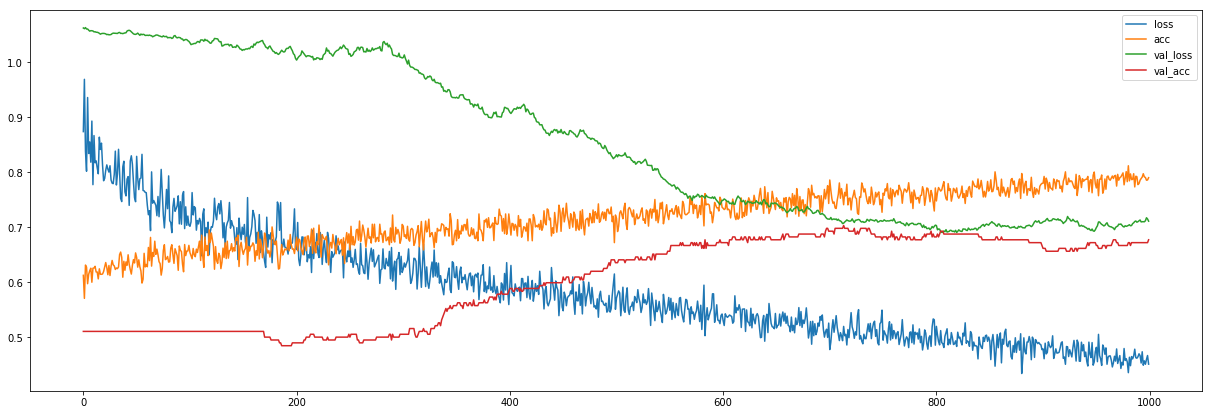

In [124]:
history.plot(figsize=(21, 7))

In [125]:
to_be_predict_set = pickle.load(open(os.path.join(sub_log_dir, 'to_be_predict_set.pkl'), 'rb'))

In [ ]:
class_list = [i for i in range(2)]
nb_class = len(class_list)
_, reverse_categorical = categorical_factory(class_list)
performance_func = performance_factory(reverse_categorical, 
                                       performance_types=['Y0', 'Y', 'returns', 
                                                          'cum_returns', 'annual_return','sharpe_ratio'], 
                                       mid_type=(nb_class-1) / 2.0, epsilon=0.3)

In [ ]:
performances = {}
for value in measure_values:
    if value in models:
        model = models[value]
        for tag in to_be_predict_set:
            performances['{}_{}'.format(value, tag)] = model_predict(model, to_be_predict_set[tag][0], to_be_predict_set[tag][1], 
                                              performance_func)
            scores = model.evaluate(to_be_predict_set[tag][1], to_be_predict_set[tag][2], verbose=1)
            performances['{}_{}'.format(value, tag)]['loss'] = scores[0]
            performances['{}_{}'.format(value, tag)]['metrics'] = scores[1]

In [ ]:
performances['0.5_validate'].keys()

In [ ]:
df_perf = pd.DataFrame(columns=['tag', 'sharpe_ratio', 'annual_return'])
test_type = 'validate'
for value in measure_values:
    tag = '{}_{}'.format(value, test_type)
    if tag in performances:
        df_perf.loc[len(df_perf)] = [tag, performances[tag]['sharpe_ratio'], performances[tag]['annual_return']]
        

In [ ]:
df_perf.sort_values('sharpe_ratio', ascending=False)

In [ ]:
test_type = 'validate'
value = 0.5
weight = 0.5

tag = '{}_{}'.format(value, test_type)
argmax = performances[tag]['Y0'].map(np.argmax) 
argmax[argmax==0] = -1
max_value = performances[tag]['Y0'].map(np.max)
signal = pd.concat([argmax, max_value], axis=1)
signal.columns = ['signal', 'weight']
signal['signal']
pct_chg = to_be_predict_set[test_type][0]['pct_chg']

cal_returns = pd.concat([signal.shift(1), pct_chg], axis=1)
cal_returns['returns'] = np.nan
cond = (cal_returns['weight'] > weight)  & (cal_returns['signal'] > 0)
returns = cal_returns['signal'] * cal_returns['pct_chg']
returns[pct_chg.shift(1) > 0.098] = np.nan
cal_returns.loc[cond, 'returns'] =  returns.loc[cond]

In [ ]:
returns = cal_returns['returns'].unstack(level=0).apply(np.mean,axis=1).fillna(0)
(returns + 1).cumprod().plot(figsize=(21, 7))

In [ ]:
import empyrical

In [ ]:
empyrical.sharpe_ratio(returns)

In [126]:
features_list = pickle.load(open(os.path.join(sub_log_dir, 'features_list.pkl'), 'rb'))

In [127]:
features = features_list[0]

In [128]:
features.columns.values

array(['close_by_window', 'volume_by_window', 'open_', 'high_', 'low_',
       'close_', 'up_down', 'high_close', 'close_low', 'high_open',
       'open_low', 'diff_high_close_low', 'diff_high_open_low', 'up',
       'down', 'wide', 'diff_up_down', 'diff_up_wide', 'diff_down_wide',
       'rsi', 'macd', 'macdsignal', 'macdhist', 'slowk', 'slowd', 'j',
       'j_k', 'j_d', 'k_d', 'close_to_upperband', 'close_to_middleband',
       'close_to_lowerband', 'upper_to_middle', 'lower_to_middle',
       'close_upper_middle_ratio', 'close_lower_middle_ratio',
       'period_idx', 'volatility_5_10', 'volatility_5_20',
       'volatility_threshold', 'pct_chg', 'ma_1_60', 'ma_2_60', 'ma_3_60',
       'ma_5_60', 'ma_8_60', 'ma_13_60', 'ma_21_60', 'label'], dtype=object)

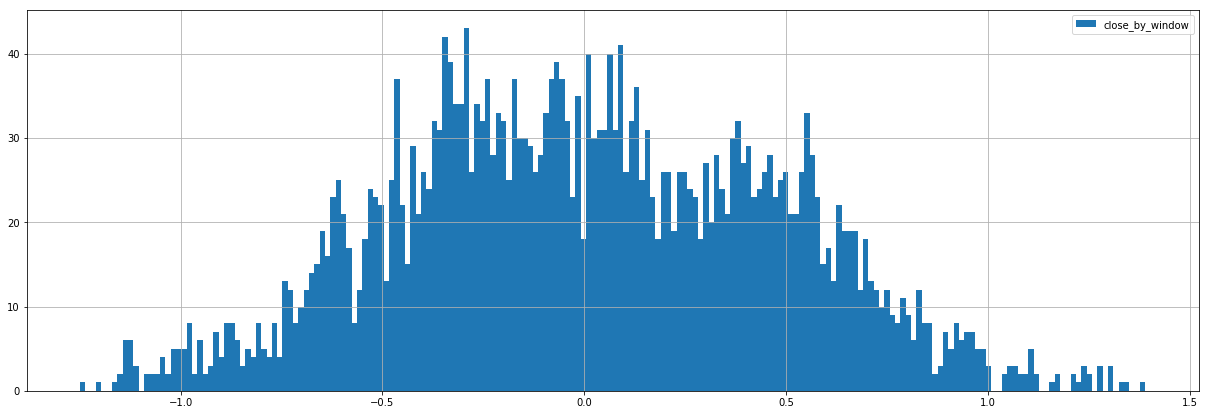

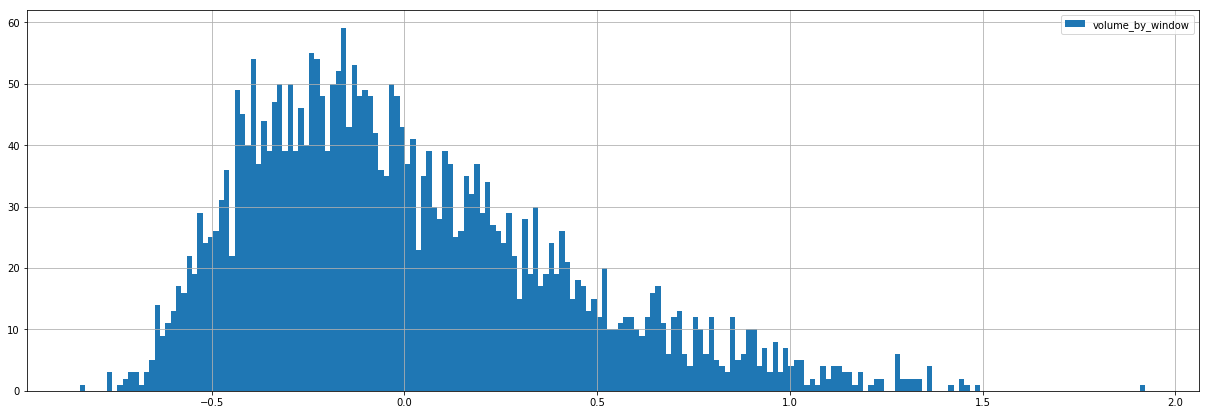

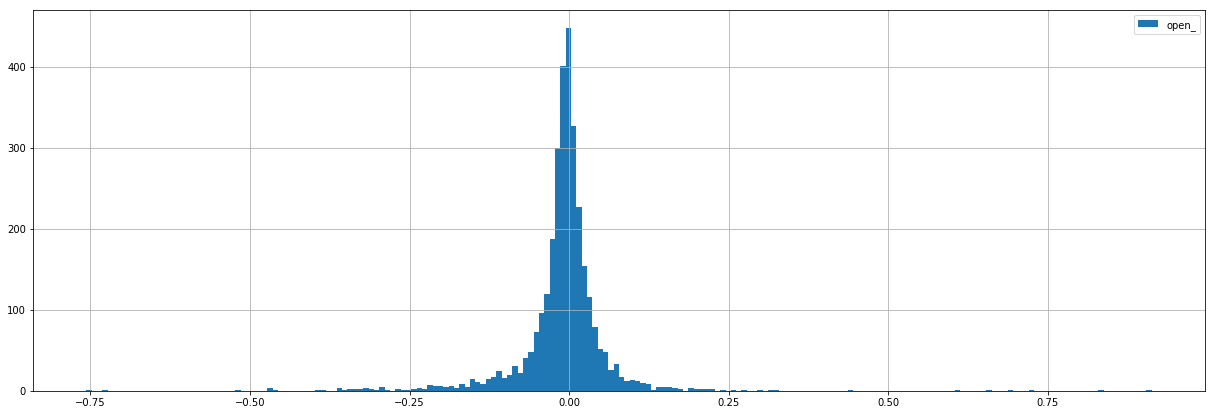

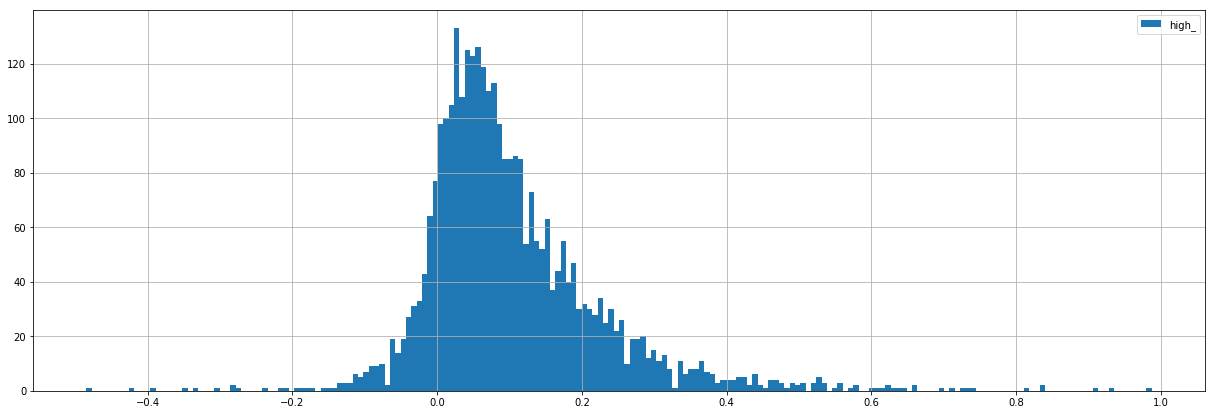

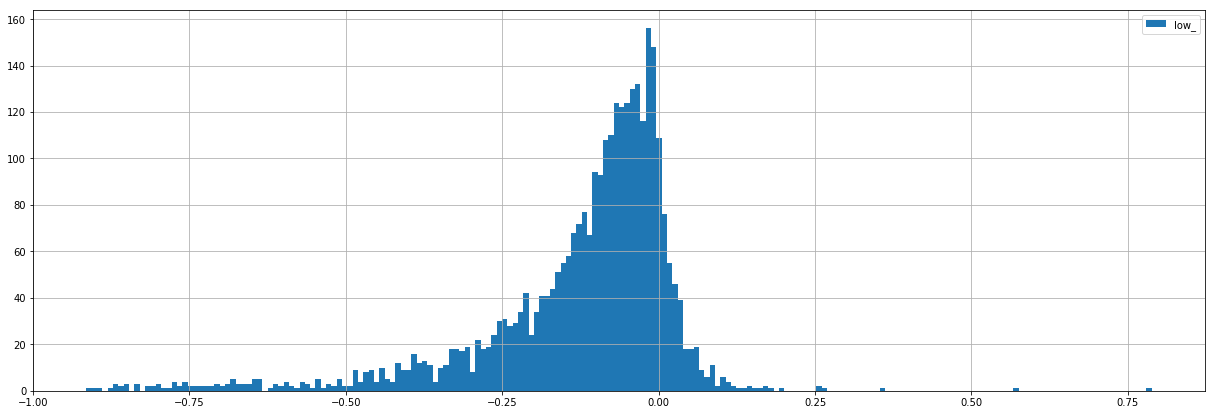

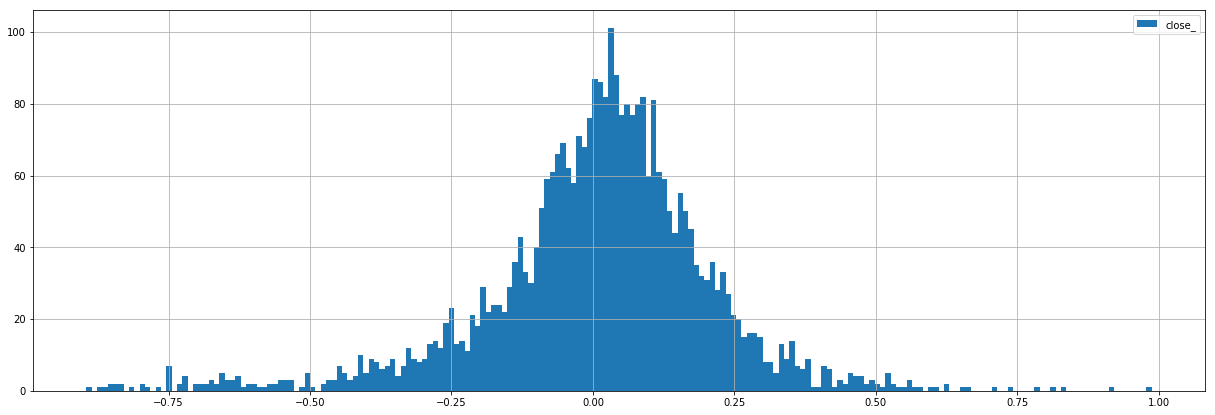

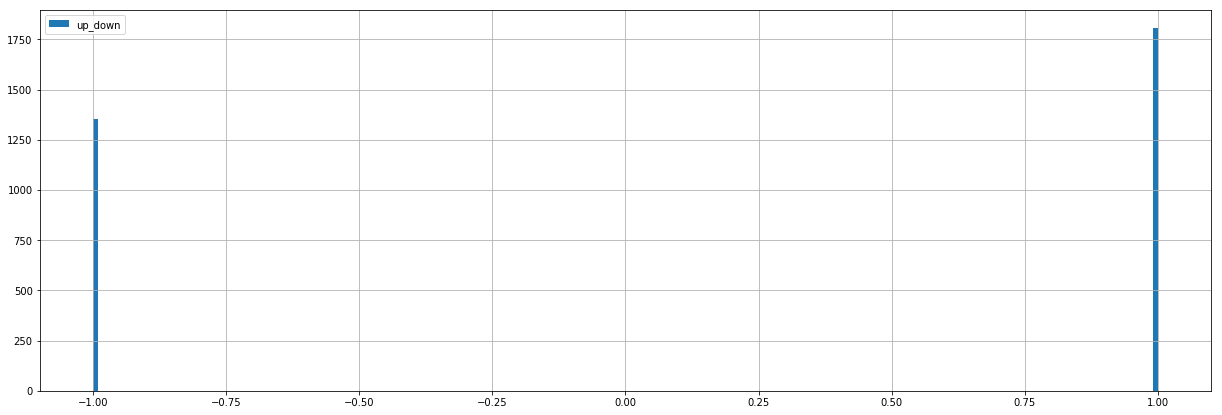

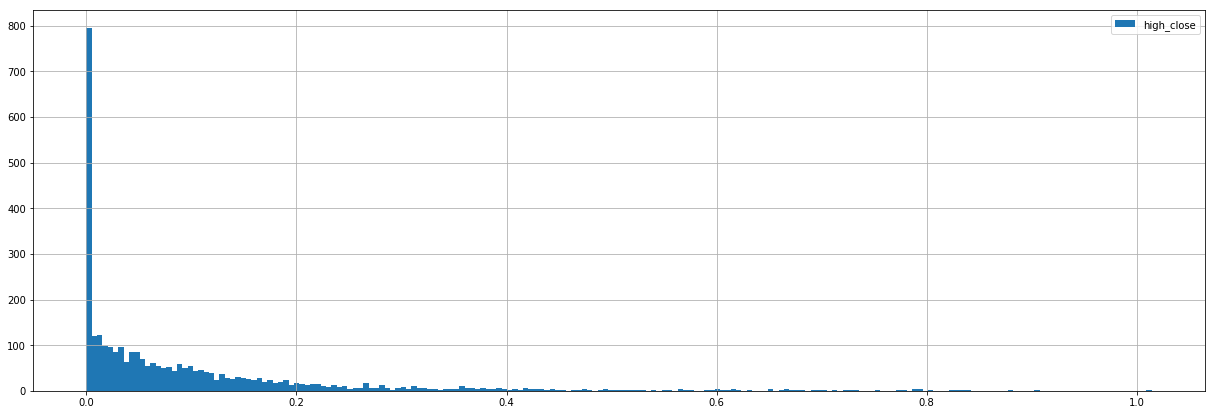

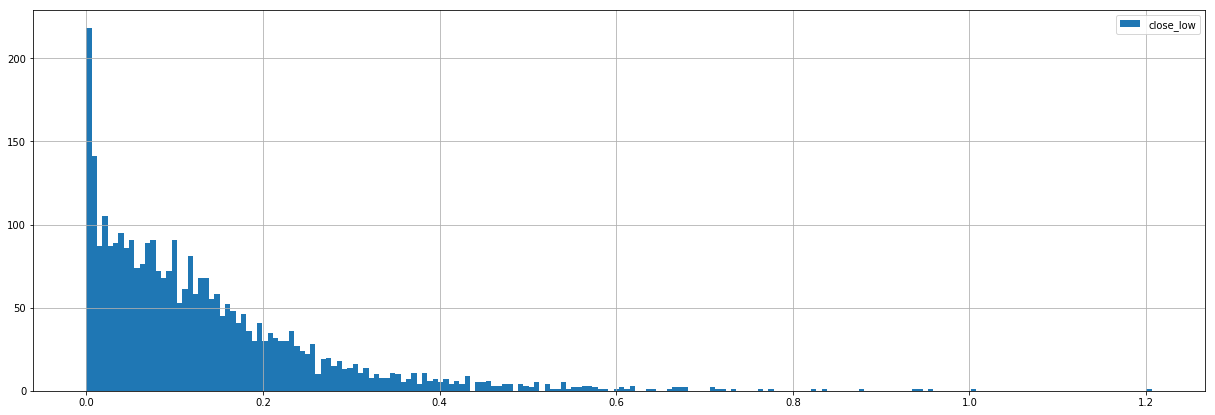

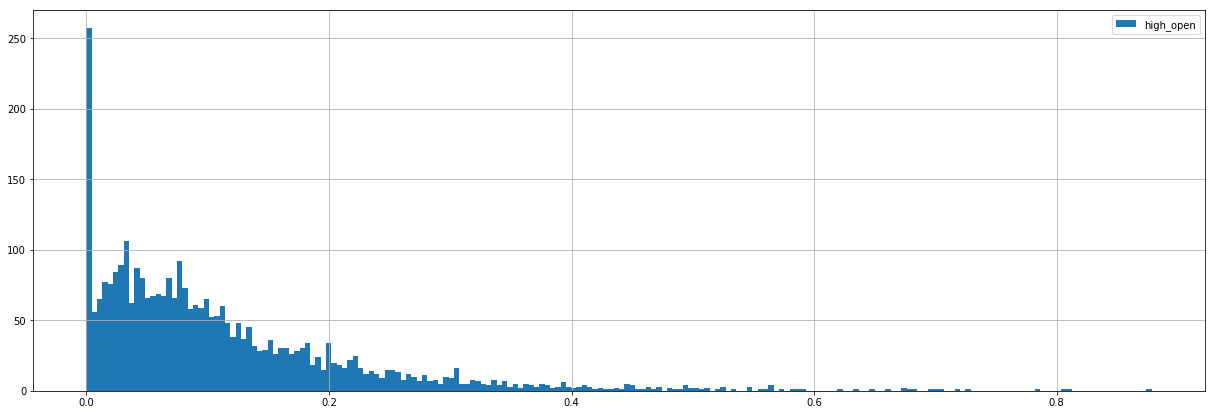

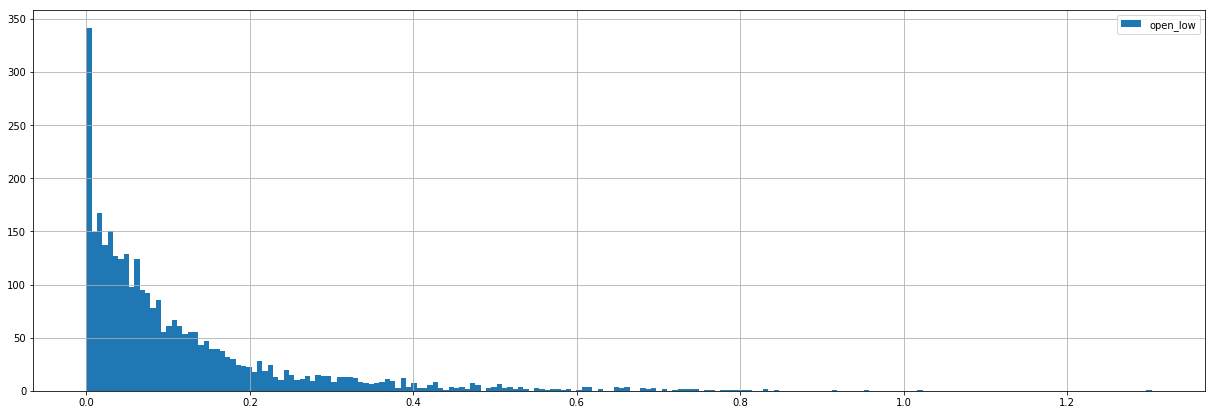

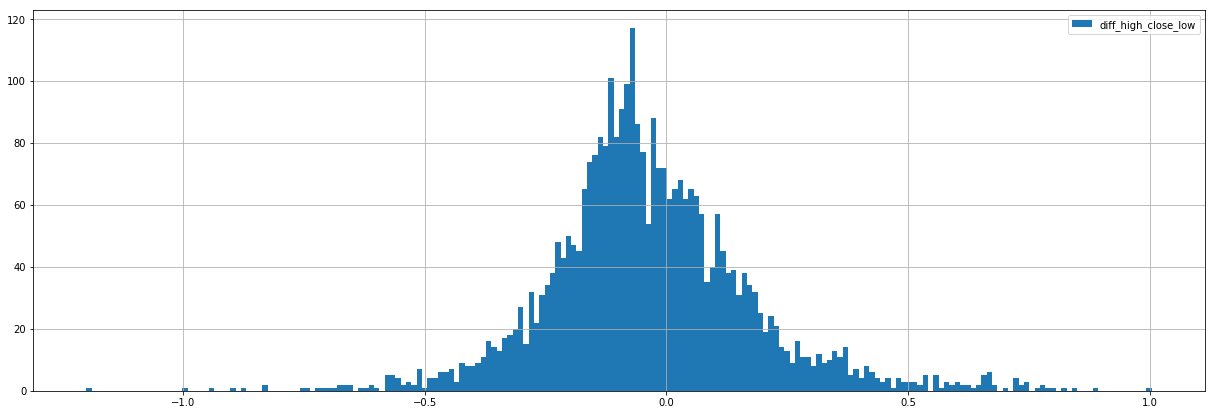

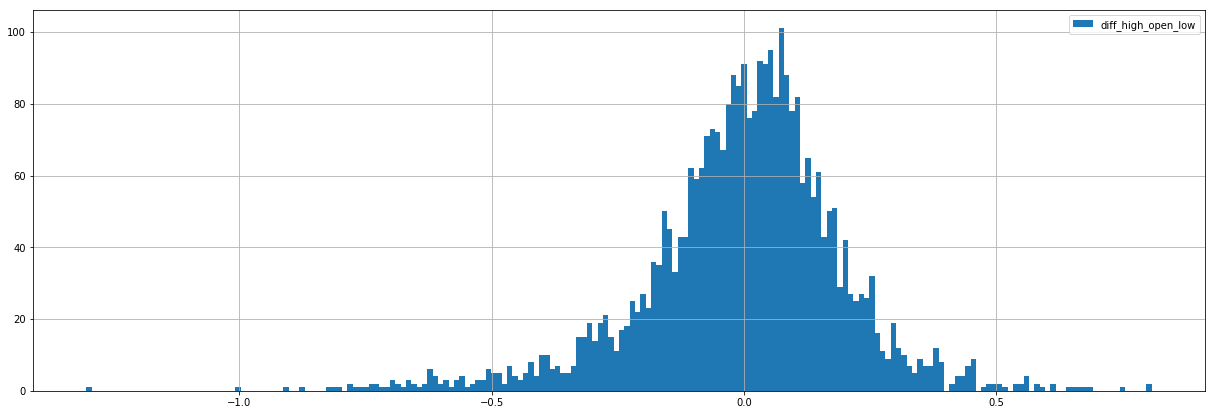

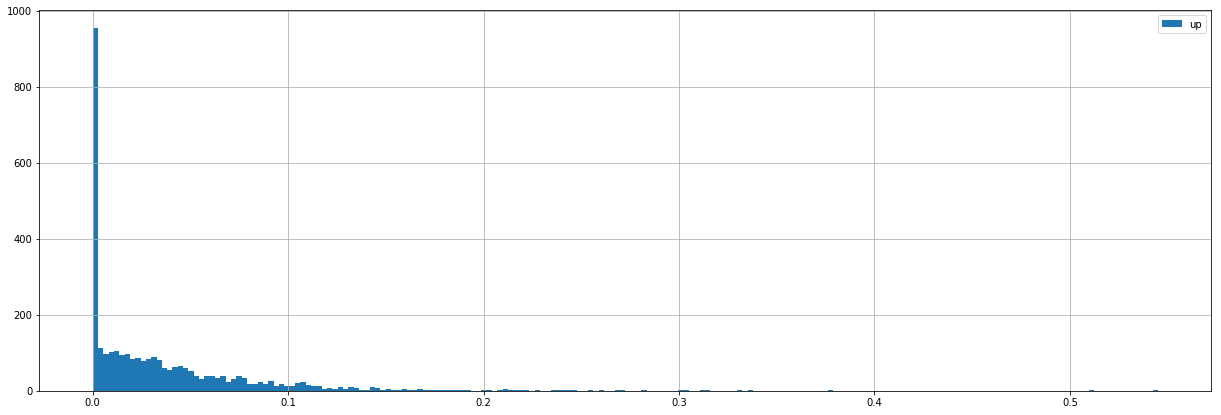

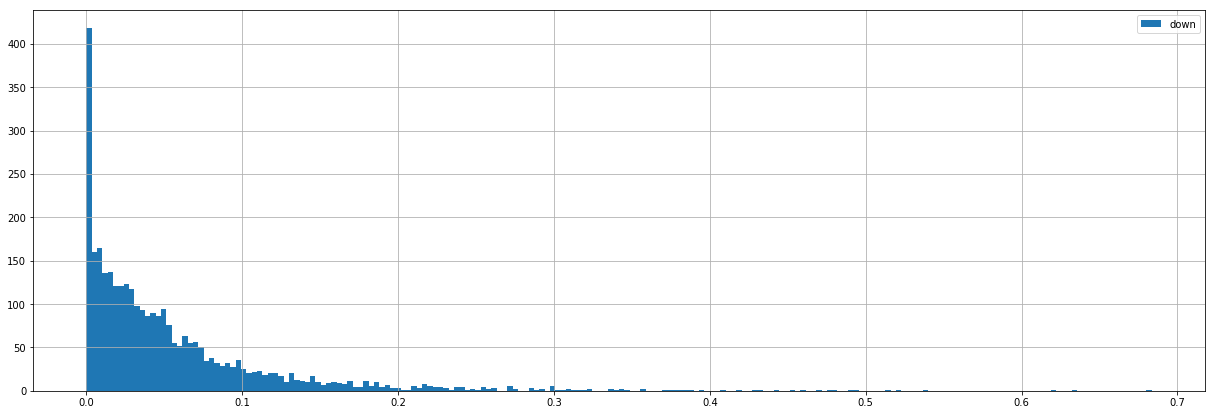

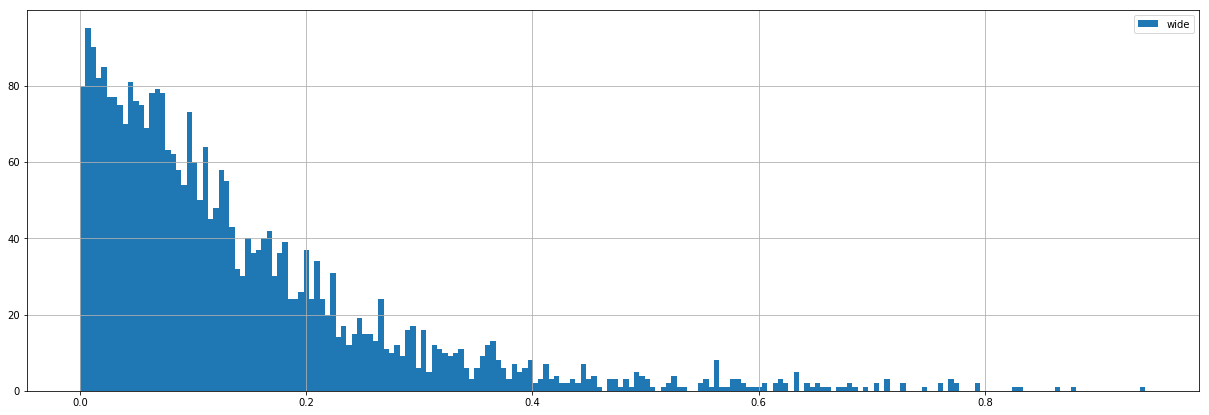

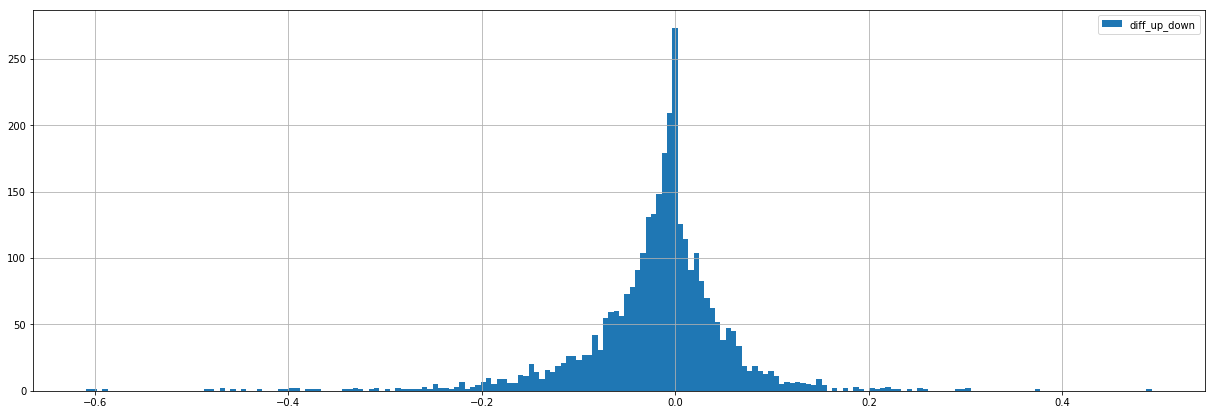

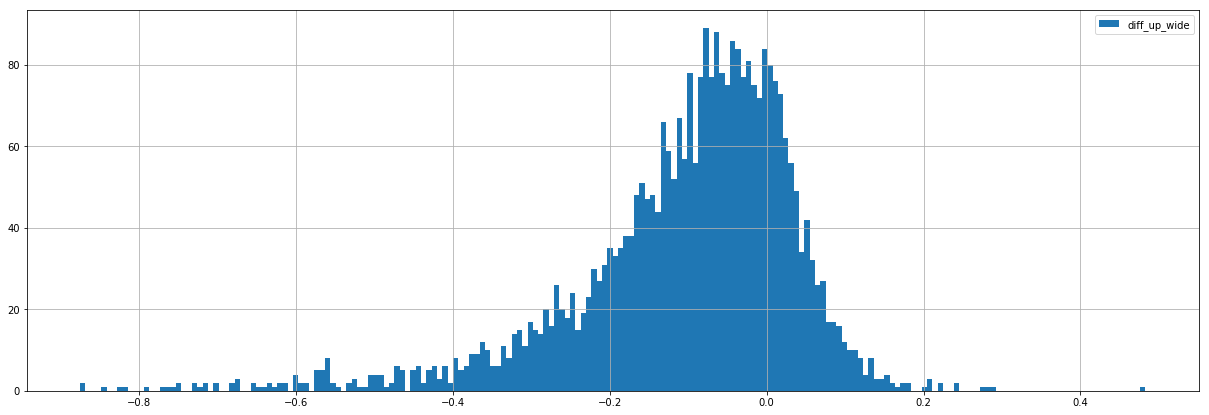

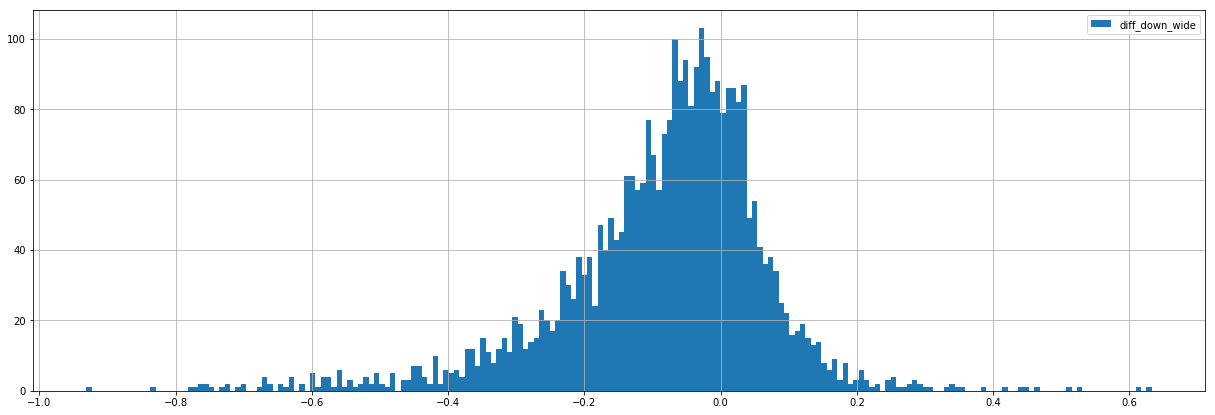

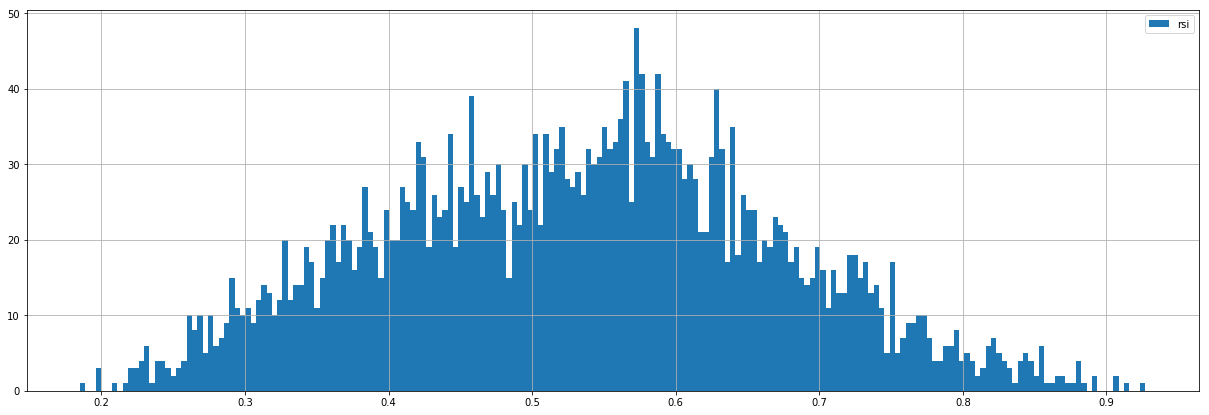

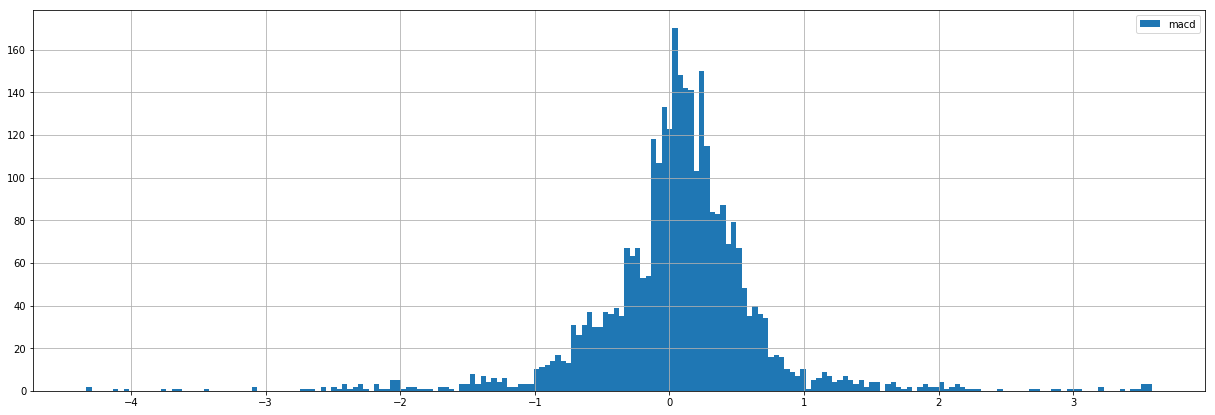

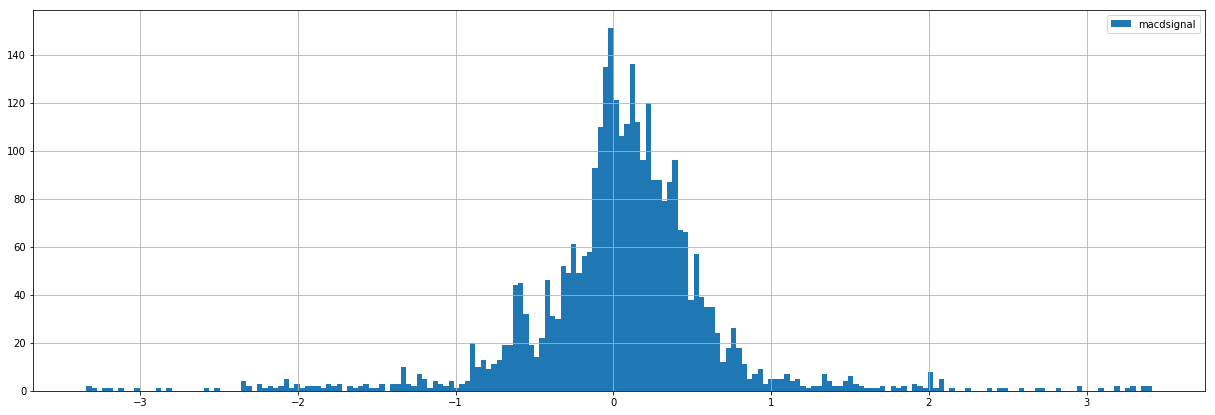

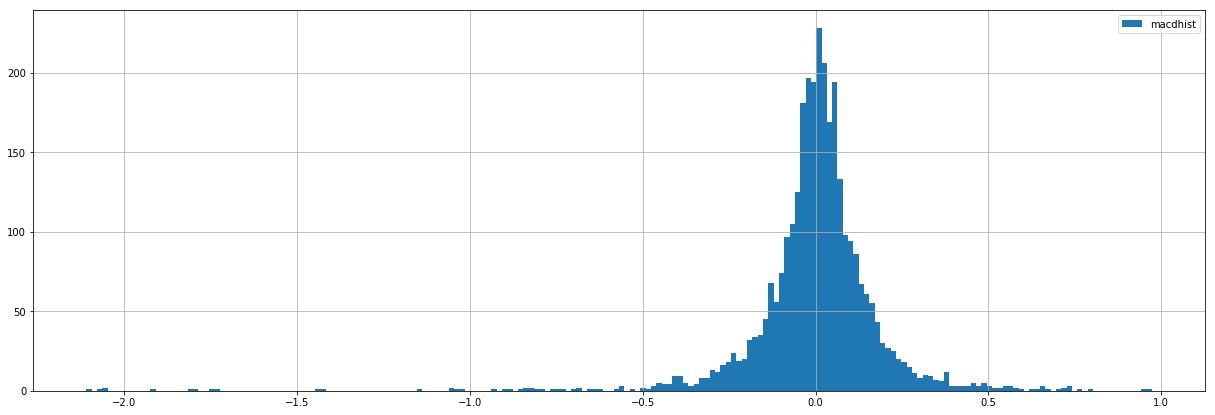

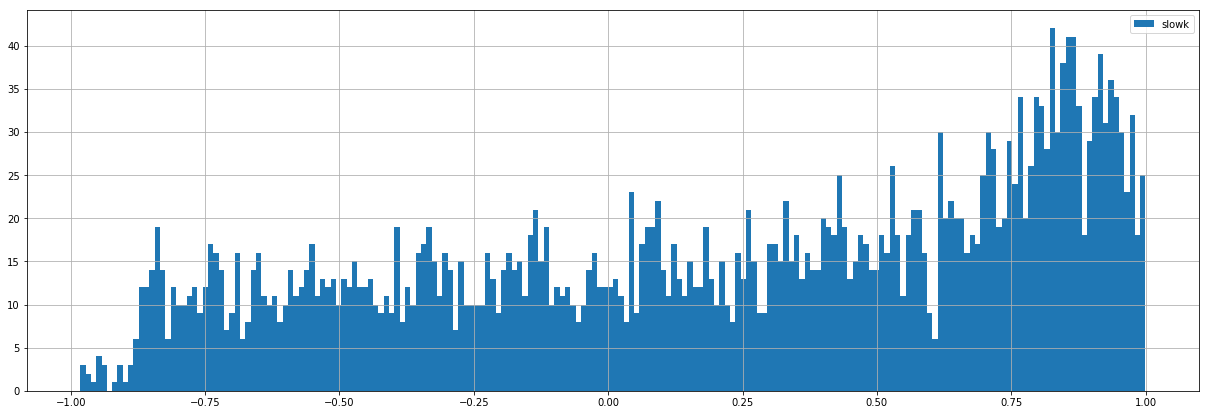

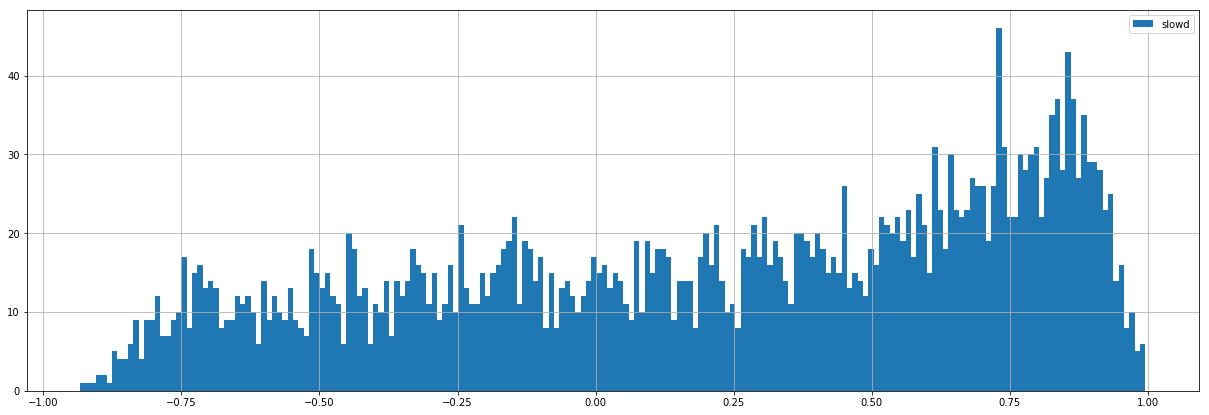

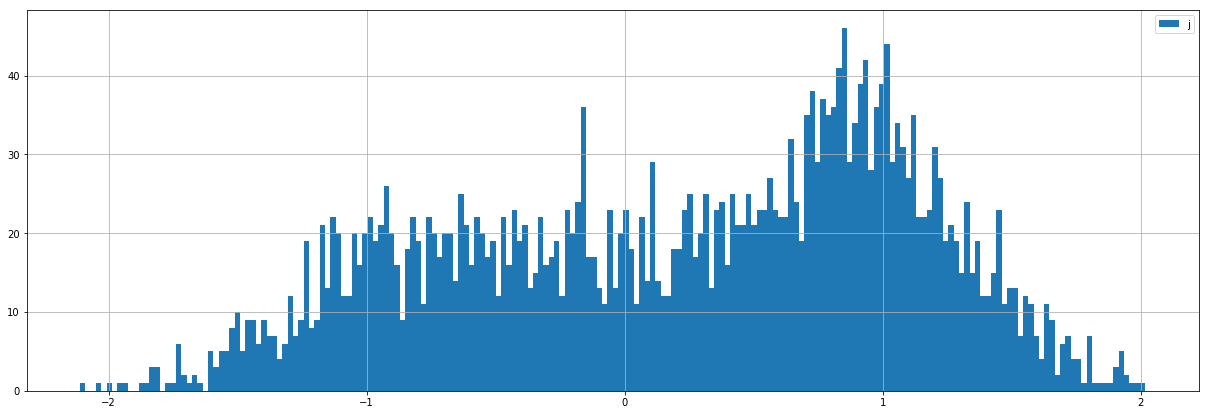

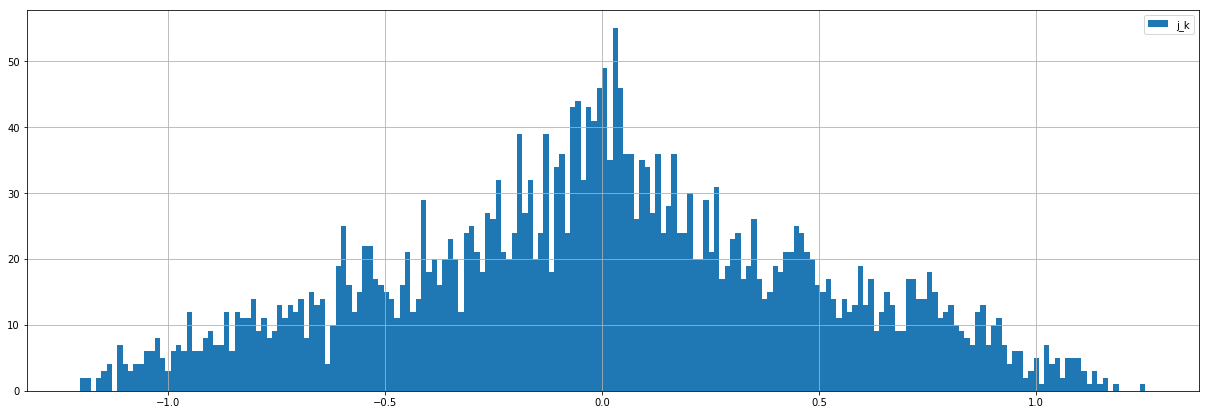

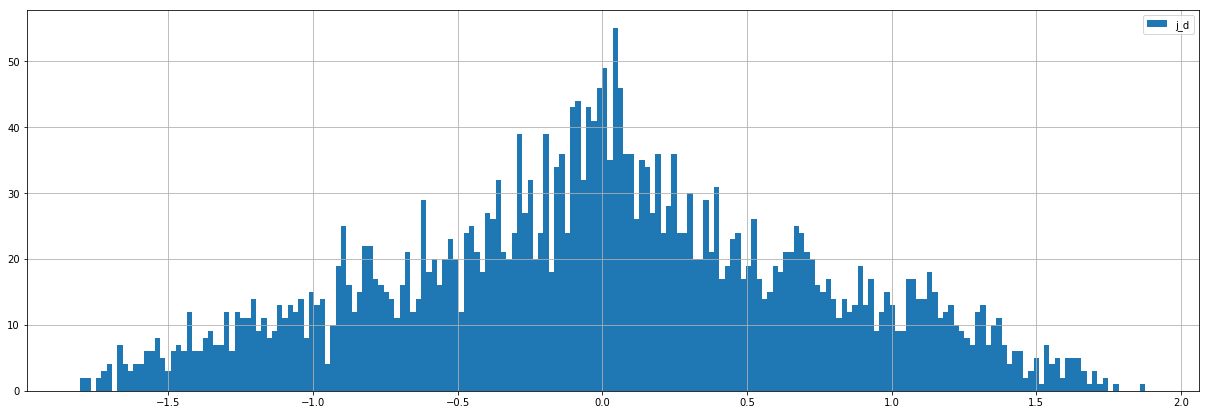

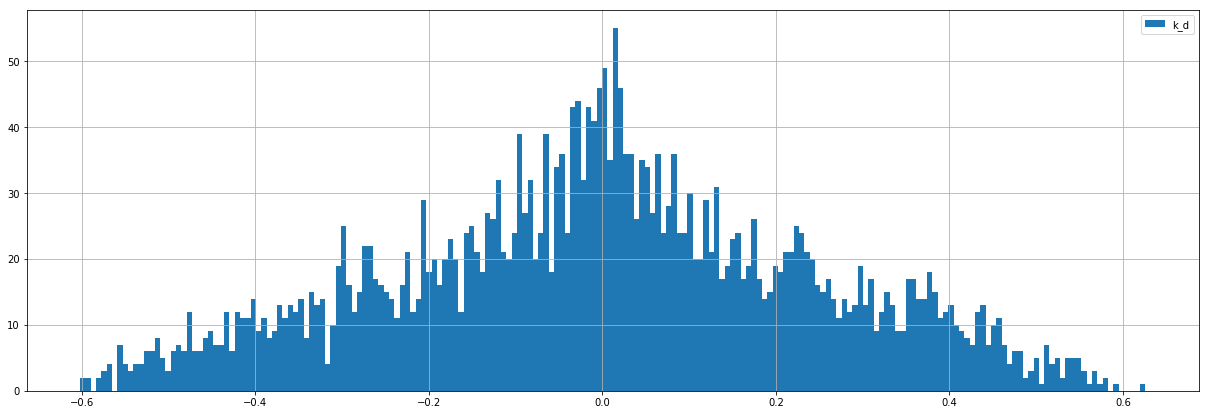

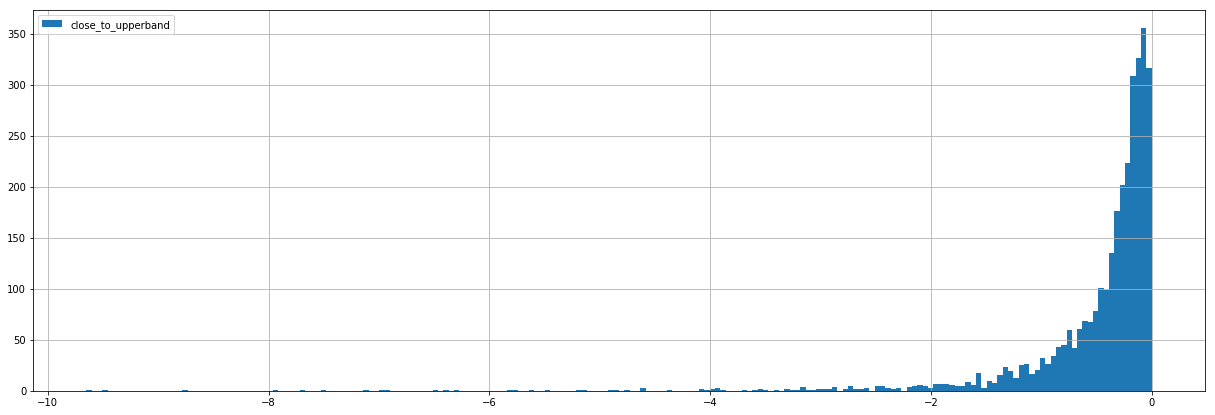

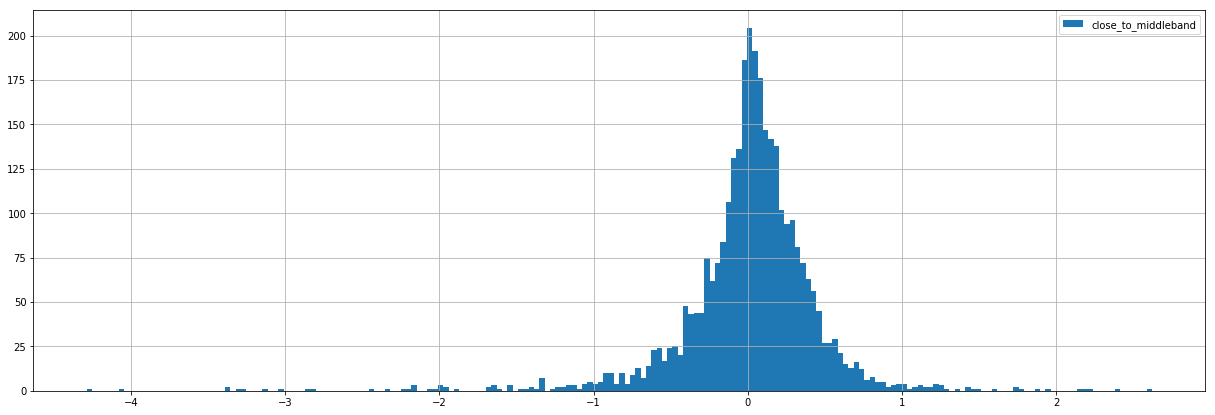

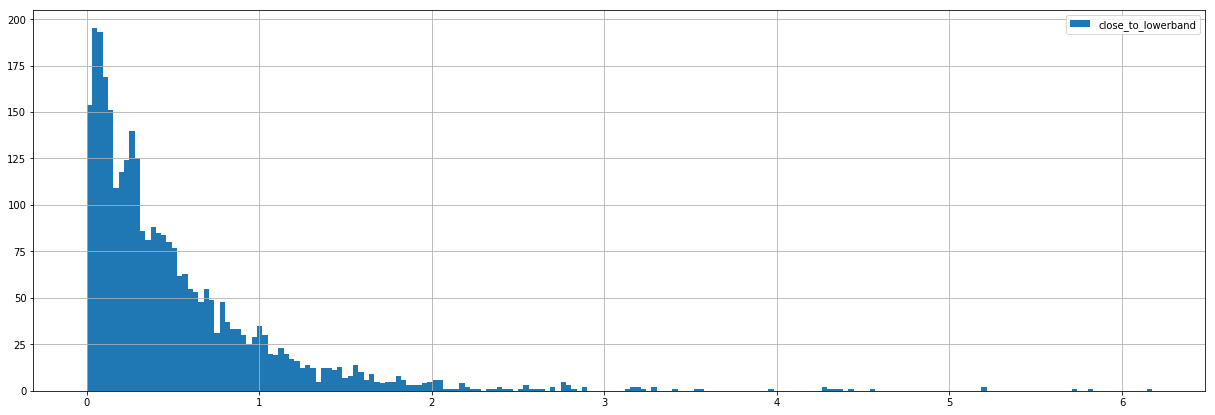

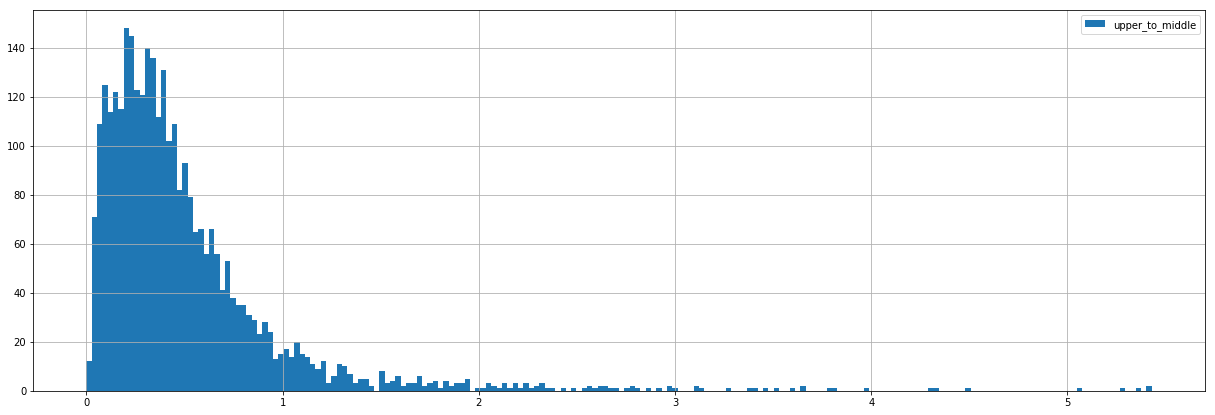

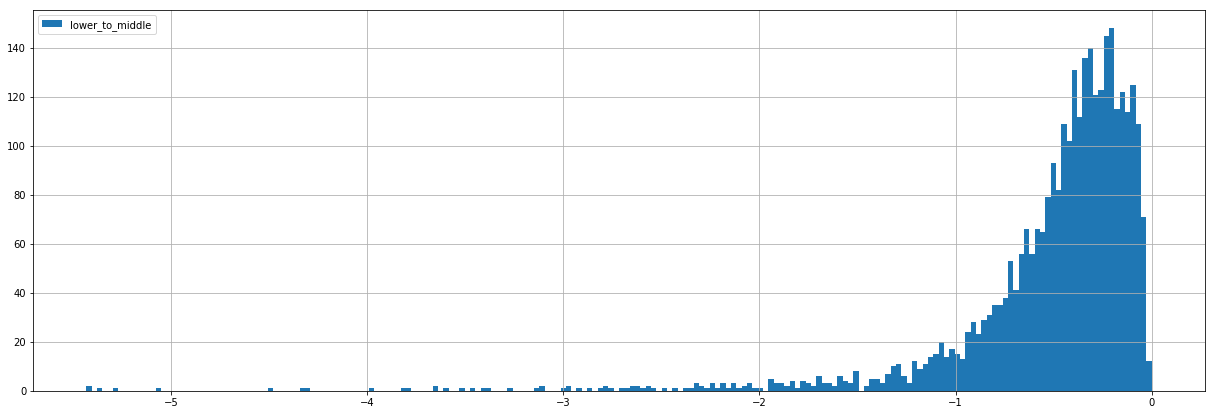

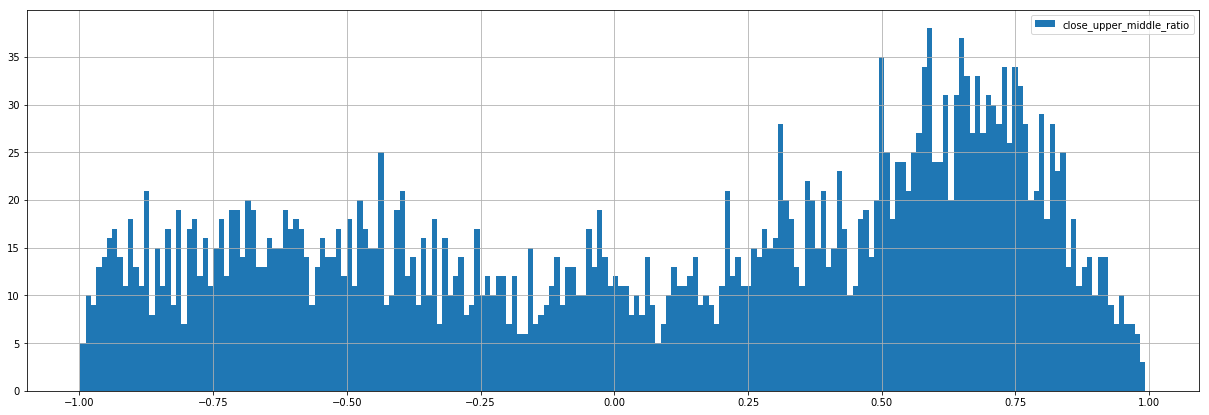

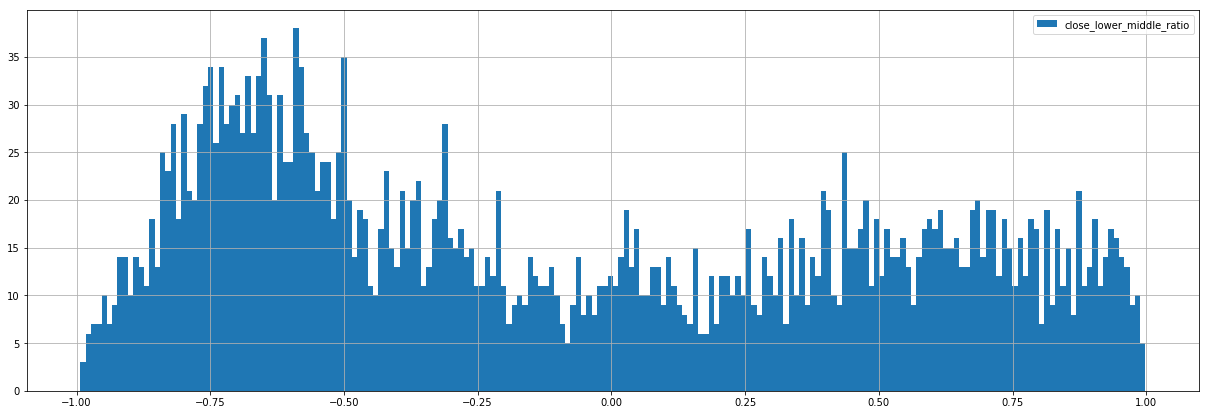

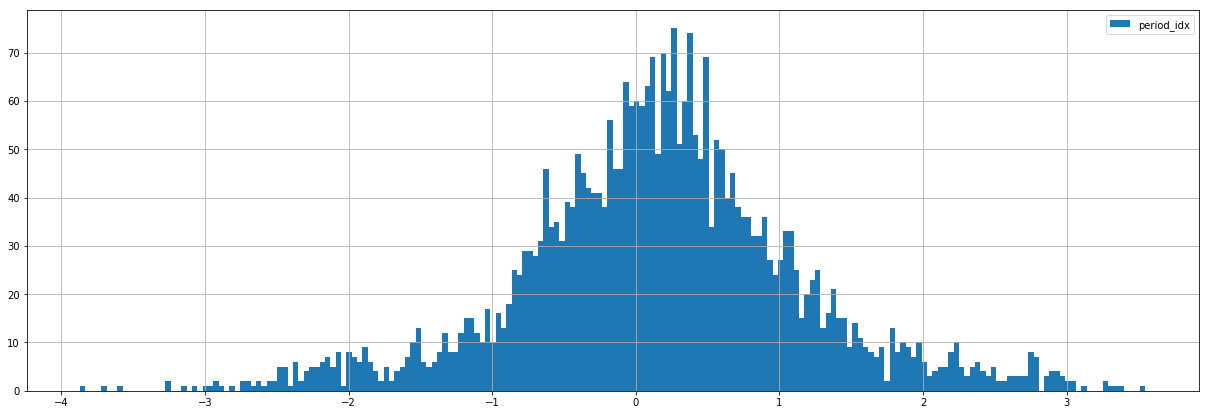

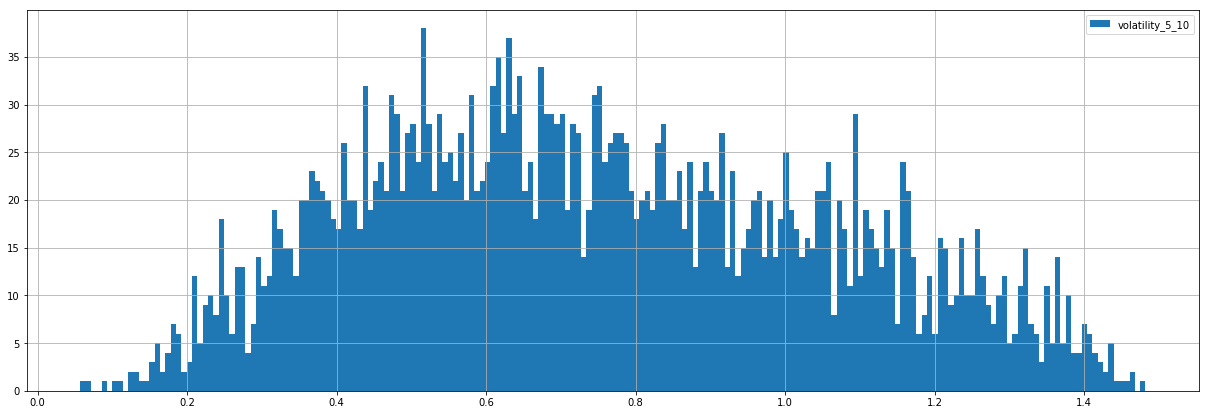

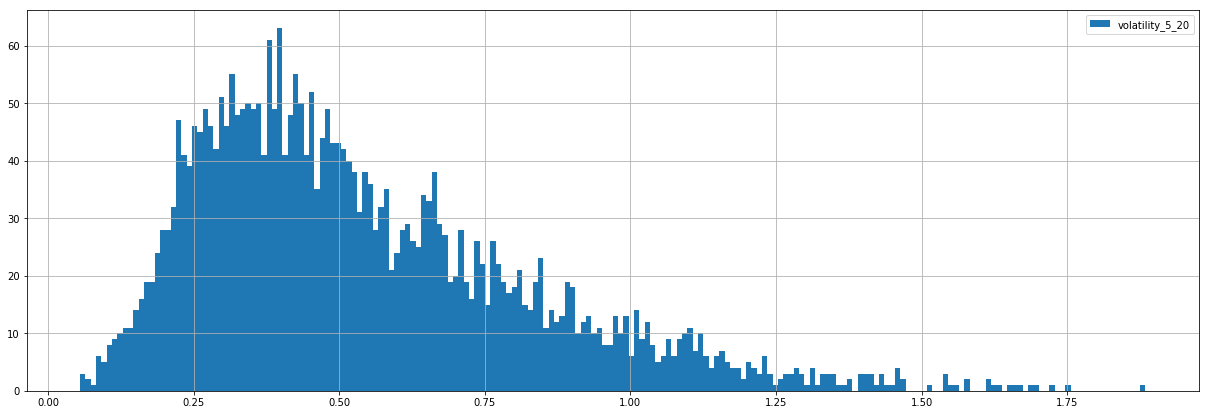

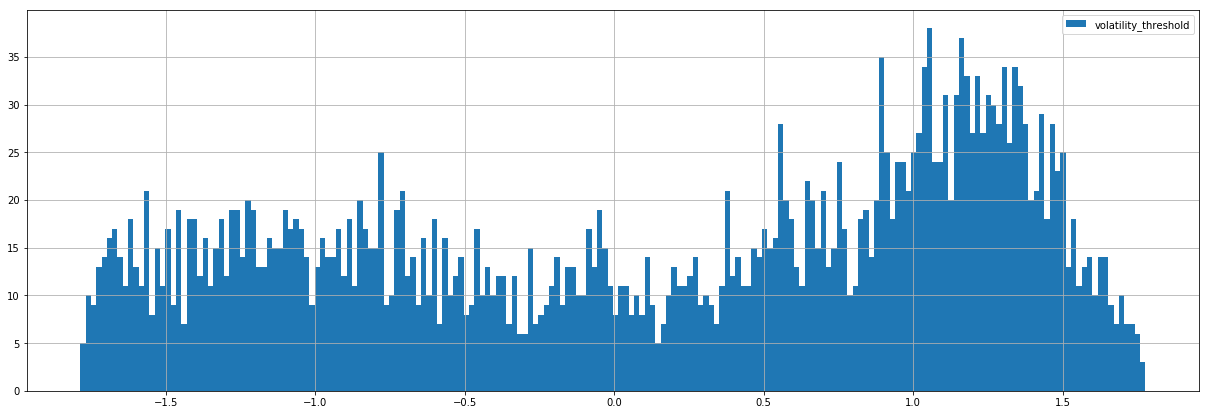

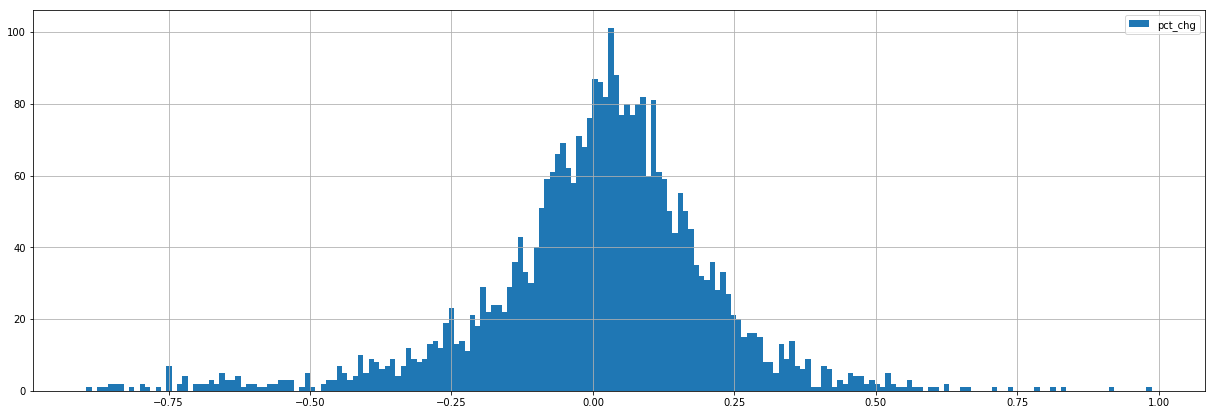

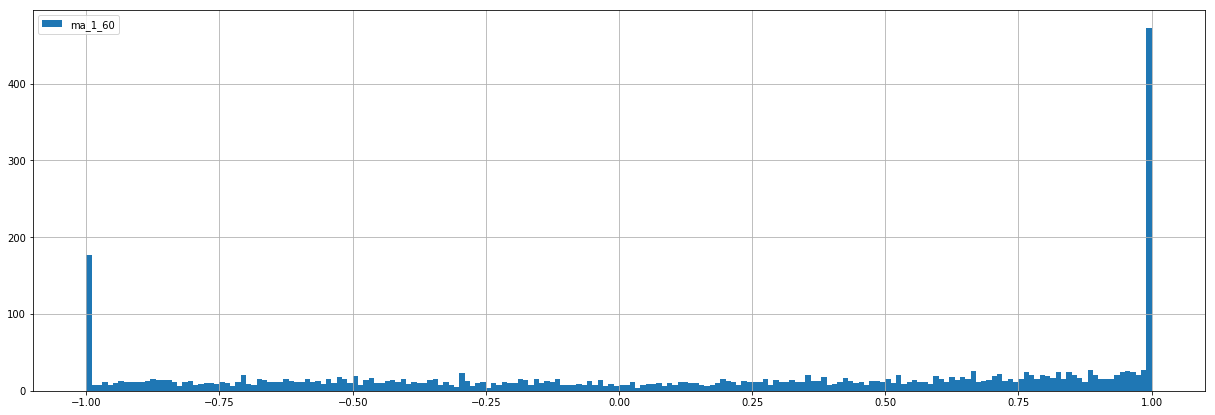

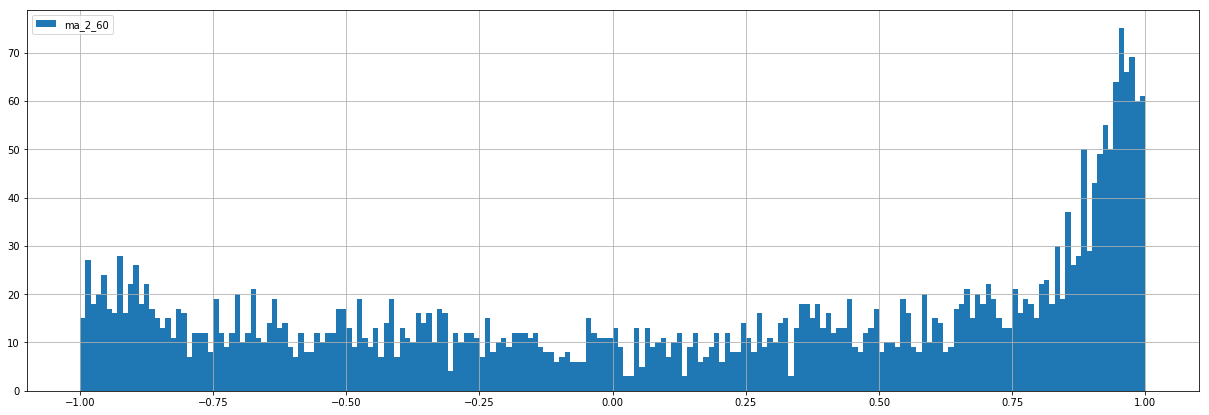

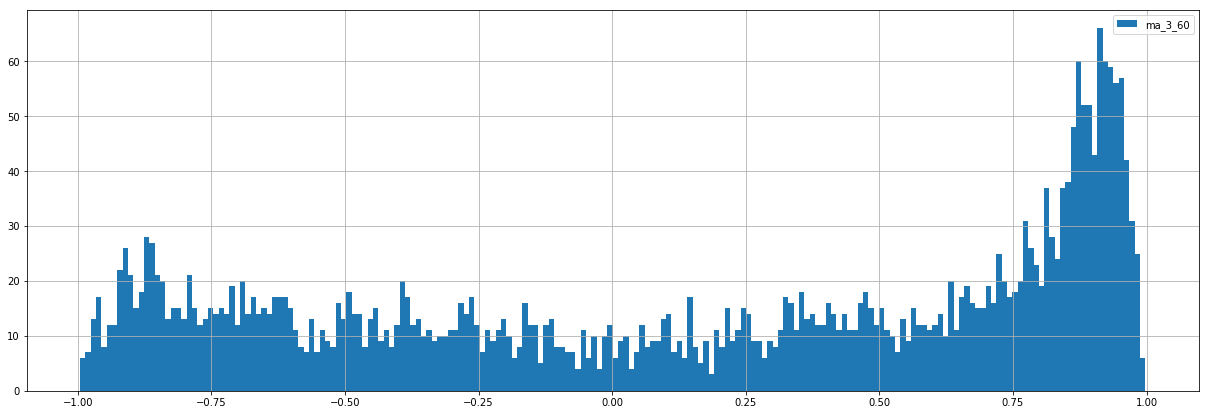

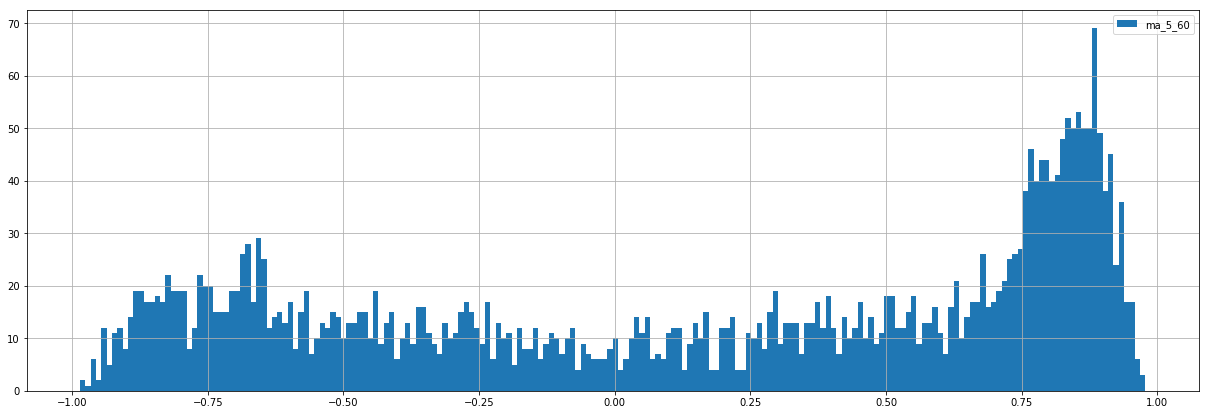

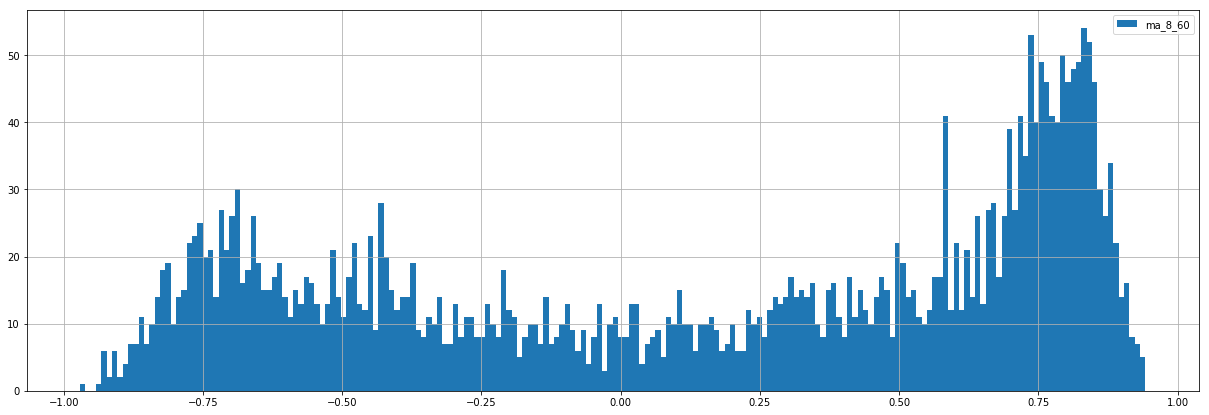

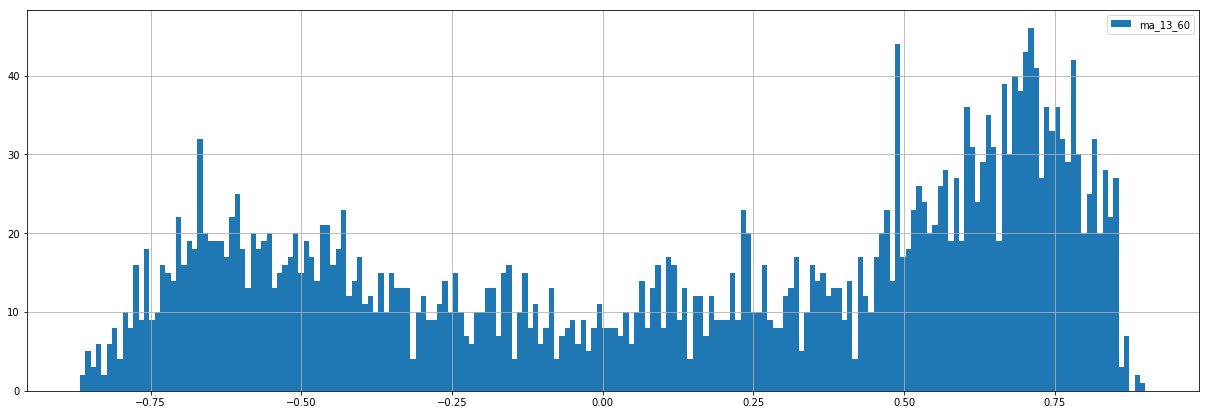

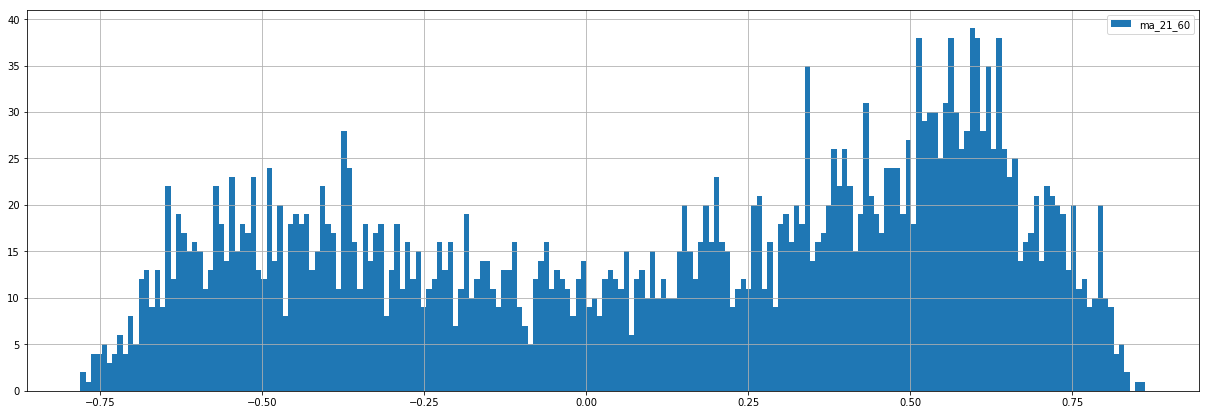

In [129]:
for i in range(len(features.columns.values)):
    if features.columns.values[i] != 'label':
        features[features.columns.values[i]].hist(bins=200, label=features.columns.values[i], figsize=(21, 7))
        plt.legend()
        plt.show()

In [130]:
performances = pickle.load(open(os.path.join(sub_log_dir, 'performances.pkl'), 'rb'))

In [131]:
performances['validate'].keys()

dict_keys(['returns', 'loss', 'metrics', 'sharpe_ratio', 'cum_returns', 'Y0', 'annual_return', 'Y'])

In [132]:
performances['validate']['annual_return']

0.0

In [133]:
ohlcv_list = pickle.load(open(os.path.join(log_dir, 'ohlcv_list.pkl'), 'rb'))

In [134]:
performances.keys()

dict_keys(['test', 'validate'])

In [135]:
Y0 = pd.concat([performances['validate']['Y0'], performances['test']['Y0']], axis=0) 
Y0_true = features['label']

In [136]:
predict = pd.concat([Y0.map(np.argmax), Y0.map(np.max)], axis=1)
predict.columns = ['signal', 'weight']
predict.loc[predict['signal']==0, 'signal'] = -1

y_true = Y0_true.map(np.argmax)
y_true.name = 'signal_true'
y_true[y_true==0] = -1

In [137]:
close = ohlcv_list[0]['close']

In [138]:
pct_chg = close.pct_change()
pct_chg.name = 'pct_change'

In [139]:
result = pd.concat([close, pct_chg, predict.shift(1), y_true.shift(1)], axis=1)

In [140]:
result = result.dropna()

In [141]:
result.head()

close  pct_change  signal    weight  signal_true
code   date                                                           
000905 2016-03-24  6018.424   -0.016431     1.0  0.779299          1.0
       2016-03-25  6077.431    0.009804     1.0  0.505325          1.0
       2016-03-28  6037.778   -0.006525    -1.0  0.509411          1.0
       2016-03-29  5921.867   -0.019198    -1.0  0.838768          1.0
       2016-03-30  6137.503    0.036414    -1.0  0.968774          1.0

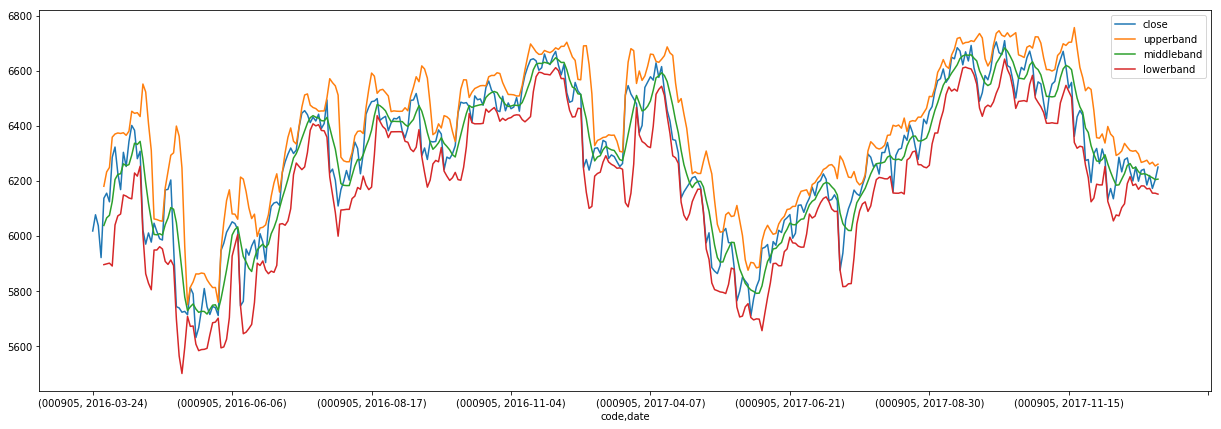

In [142]:
from talib.abstract import *
bbands = BBANDS(result)
result = pd.concat([result, bbands], axis=1)
result[['close', 'upperband', 'middleband', 'lowerband']].plot(figsize=(21, 7))

Index(['index', 'code', 'date', 'close', 'pct_change', 'signal', 'weight',
       'signal_true', 'upperband', 'middleband', 'lowerband'],
      dtype='object')


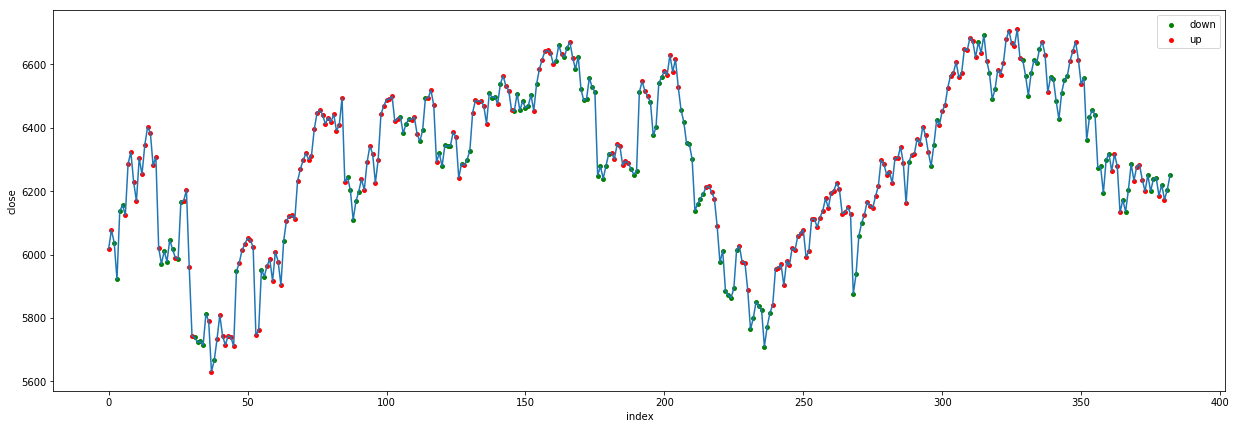

In [143]:
f = result.reset_index().reset_index()
print(f.columns)
col = 'signal'
fig, ax = plt.subplots(1, figsize=(21, 7))
f.loc[:, 'close'].plot(figsize=(21, 7))
f[f[col] == -1].plot.scatter(x='index', y='close', s=15, c='green', figsize=(21, 7), ax=ax, label="down")
f[f[col] == 1].plot.scatter(x='index', y='close', s=15, c='red', figsize=(21, 7), ax=ax, label="up")
plt.show()

In [144]:
# f = result.reset_index().reset_index()
# print(f.columns)
# col = 'signal_true'
# fig, ax = plt.subplots(1, figsize=(21, 7))
# f.loc[:, 'close'].plot(figsize=(21, 7))
# f[f[col] == -1].plot.scatter(x='index', y='close', s=15, c='green', figsize=(21, 7), ax=ax, label="down")
# f[f[col] == 1].plot.scatter(x='index', y='close', s=15, c='red', figsize=(21, 7), ax=ax, label="up")
# plt.show()

In [145]:
returns = result['pct_change'] * result['signal']
returns[result['weight'] < 0.6] = 0

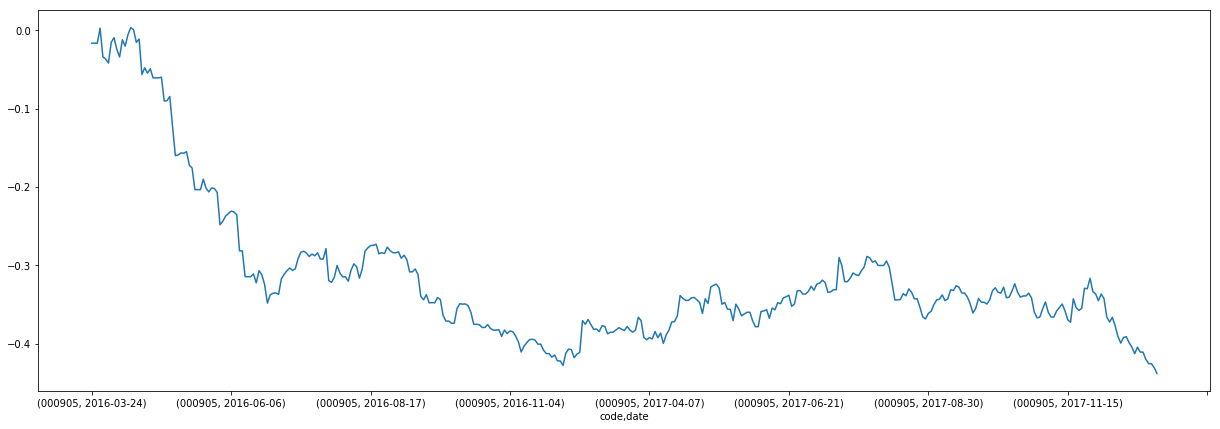

In [146]:
(returns.fillna(0)).cumsum().plot(figsize=(21, 7))

In [147]:
long_cond = (result['close'].shift(1) > result['middleband'].shift(1)) & (result['signal'] >0)
short_cond = (result['close'].shift(1) < result['middleband'].shift(1)) & (result['signal'] <0)

In [148]:
long_signal = result.loc[long_cond, 'signal'].copy()
short_signal = result.loc[short_cond, 'signal'].copy()

In [118]:
long_returns = long_signal * result['pct_change']
short_returns = short_signal * result['pct_change']

In [119]:
returns = short_returns.fillna(0) #long_returns.fillna(0) #+ short_returns.fillna(0)

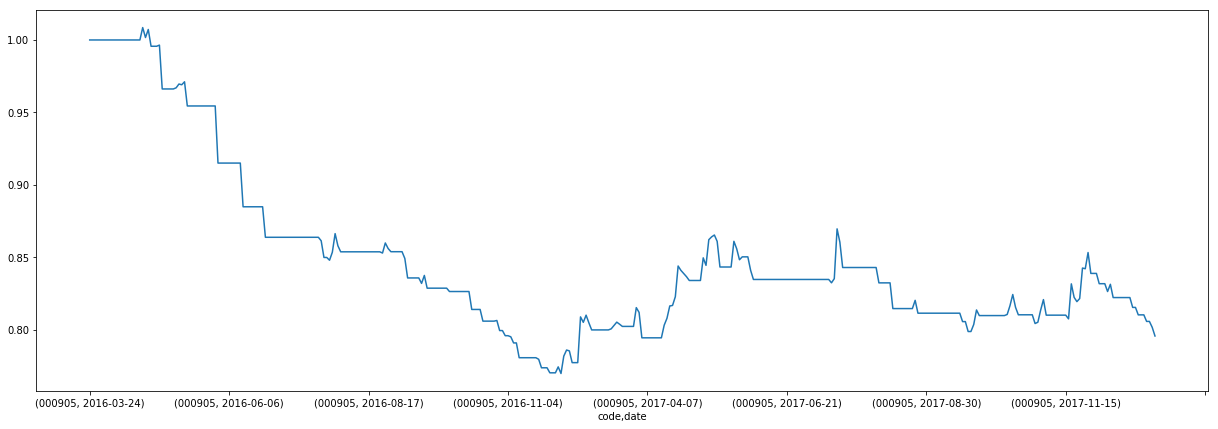

In [120]:
(returns + 1).cumprod().plot(figsize=(21, 7))

In [33]:
result

close  pct_change  signal    weight  signal_true  \
code   date                                                               
000905 2016-03-24  6018.4240   -0.016431     1.0  0.910137          1.0   
       2016-03-25  6077.4310    0.009804    -1.0  0.554486          1.0   
       2016-03-28  6037.7780   -0.006525     1.0  0.731699          1.0   
       2016-03-29  5921.8670   -0.019198    -1.0  0.800066          1.0   
       2016-03-30  6137.5030    0.036414    -1.0  0.957753          1.0   
       2016-03-31  6155.8140    0.002983     1.0  0.829304          1.0   
       2016-04-01  6124.5280   -0.005082     1.0  0.977800          1.0   
       2016-04-05  6286.5830    0.026460     1.0  0.870538          1.0   
       2016-04-06  6323.4340    0.005862     1.0  0.988323          1.0   
       2016-04-07  6228.9740   -0.014938     1.0  0.994522          1.0   
       2016-04-08  6168.7420   -0.009670     1.0  0.560159          1.0   
       2016-04-11  6304.3000    0.021975    -1.0  0.902955          1.0   
       2016-04-12  6252.7730   -0.008173     1.0  0.772882          1.0   
       2016-04-13  6344.2260    0.014626    -1.0  0.697402          1.0   
       2016-04-14  6401.8550    0.009084     1.0  0.962156          1.0   
       2016-04-15  6384.3500   -0.002734     1.0  0.995140          1.0   
       2016-04-18  6281.2020   -0.016156     1.0  0.925957         -1.0   
       2016-04-19  6308.2290    0.004303    -1.0  0.724267         -1.0   
       2016-04-20  6022.2130   -0.045340    -1.0  0.553314         -1.0   
       2016-04-21  5970.6820   -0.008557    -1.0  0.971631         -1.0   
       2016-04-22  6011.3200    0.006806    -1.0  0.979382         -1.0   
       2016-04-25  5978.0770   -0.005530    -1.0  0.838947         -1.0   
       2016-04-26  6046.7730    0.011491    -1.0  0.922695         -1.0   
       2016-04-27  6016.6990   -0.004974     1.0  0.868562         -1.0   
       2016-04-28  5990.3290   -0.004383     1.0  0.675640         -1.0   
       2016-04-29  5985.5940   -0.000790    -1.0  0.720980         -1.0   
       2016-05-03  6167.4540    0.030383    -1.0  0.867745         -1.0   
       2016-05-04  6169.7830    0.000378     1.0  0.868050         -1.0   
       2016-05-05  6203.8170    0.005516     1.0  0.960400         -1.0   
       2016-05-06  5961.4890   -0.039061     1.0  0.990291         -1.0   
...                      ...         ...     ...       ...          ...   
       2017-11-20  6433.1702    0.011196    -1.0  0.981900         -1.0   
       2017-11-21  6456.3520    0.003603    -1.0  0.835789         -1.0   
       2017-11-22  6439.4419   -0.002619    -1.0  0.553821         -1.0   
       2017-11-23  6274.5116   -0.025613    -1.0  0.837937         -1.0   
       2017-11-24  6278.0287    0.000561    -1.0  0.980790         -1.0   
       2017-11-27  6194.5522   -0.013297    -1.0  0.909236         -1.0   
       2017-11-28  6299.3122    0.016912    -1.0  0.980243         -1.0   
       2017-11-29  6318.3684    0.003025    -1.0  0.563491         -1.0   
       2017-11-30  6263.4210   -0.008696     1.0  0.866430         -1.0   
       2017-12-01  6316.4072    0.008460    -1.0  0.577730         -1.0   
       2017-12-04  6279.6206   -0.005824     1.0  0.884859         -1.0   
       2017-12-05  6132.9120   -0.023363    -1.0  0.775110         -1.0   
       2017-12-06  6172.8031    0.006504    -1.0  0.980958         -1.0   
       2017-12-07  6135.4702   -0.006048    -1.0  0.908214          1.0   
       2017-12-08  6203.1433    0.011030    -1.0  0.977630          1.0   
       2017-12-11  6286.1656    0.013384    -1.0  0.522446          1.0   
       2017-12-12  6233.2115   -0.008424     1.0  0.929370          1.0   
       2017-12-13  6277.4410    0.007096     1.0  0.640338          1.0   
       2017-12-14  6284.0807    0.001058     1.0  0.906349          1.0   
       2017-12-15  6235.7608   -0.007689     1.0  0.943358          1.0   
       2017-12-18  6199.9889   -0.005737    -1.0